# Imaging

Here, we show a quick example of imaging using *imaging.lbfgs* module. In this notebook, we do not go to details of its theoretical backgroud nor practical imaging procedures; here we focus on going through the basic functions. We also note that the imaging function has been dynamical updated, so its usage may change on short time scales.  Here, we use a [VLBA data set of 3C 273 at 43 GHz](3C273DEC16.UVP) of [the Boston University Blazar Group](https://www.bu.edu/blazars/VLBAproject.html).

In [1]:
%matplotlib inline
from smili import uvdata,imdata,imaging,util

# for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from IPython.display import IFrame

## Closure Imaging

First, you need to load the uvfits data into **uvdata.UVFITS** object. 

In [2]:
# Load the UVFITS and FITS for a sample image
uvfits = uvdata.UVFITS("3C273DEC16.UVP").select_stokes("I").avspc() # select Stokes I and average over multiple IFs

Filename: 3C273DEC16.UVP
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU      155   (3, 4, 1, 4, 1, 1)   float32   1913 Groups  7 Parameters
  1  AIPS NX       1 BinTableHDU     31   8R x 7C   [1E, 1E, 1J, 1J, 1J, 1J, 1J]   
  2  AIPS FQ       1 BinTableHDU     29   1R x 6C   [1J, 4D, 4E, 4E, 4J, 32A]   
  3  AIPS AN       1 BinTableHDU     72   10R x 14C   [8A, 3D, 0D, 1J, 1J, 1E, 1E, 4E, 1A, 1E, 8E, 1A, 1E, 8E]   

Loading HDUs in the input UVFITS files.
  Primary HDU was loaded.
  AIPS FQ Table was loaded.
  Subarray 1 was found in an AIPS AN table

Checking loaded HDUs.
  1 Subarray settings are found.
  No AIPS SU tables were found.
    Assuming that this is a single source UVFITS file.

Reading FQ Tables
  Frequency Setup ID: 1
    IF Freq setups (Hz):
         if_freq_offset  ch_bandwidth  if_bandwidth  sideband
      0             0.0    64000000.0    64000000.0         1
      1      80000000.0    64000000.0    64000000.0         1


/Users/akiyama/.pyenv/versions/anaconda2-5.3.1/lib/python2.7/site-packages/astropy/io/fits/fitsrec.py:687: UserWarning: Field 'ORBPARM' has a repeat count of 0 in its format code, indicating an empty field.
  'indicating an empty field.'.format(key))


  VisData.sort: 0 indexes have wrong station orders (ant1 > ant2).
  VisData.sort: Data have been sorted by utc, ant1, ant2, subarray
Stokes I data will be calculated from input RR and LL data


As you can see the above log, this data set has full Stokes parameters. Here, we average data over IFs and select Stokes I.
Then we create visibility tables.

In [3]:
# Table objects of visibilities
vtable = uvfits.make_vistable() # Complex Visibilities
btable = vtable.make_bstable()  # Bispectra
ctable = vtable.make_catable()  # Log closure amplitudes

  5%|▍         | 93/1912 [00:00<00:01, 923.43it/s]

(1/5) Sort data
(2/5) Tagging data


 32%|███▏      | 20/62 [00:00<00:00, 197.23it/s]

  Number of Tags: 62
(3/5) Checking Baseline Combinations


  2%|▏         | 1/62 [00:00<00:11,  5.19it/s]

  Detect 22 combinations for Closure Phases
(4/5) Forming Closure Phases


  5%|▌         | 98/1912 [00:00<00:01, 971.01it/s]

(5/5) Creating BSTable object
(1/5) Sort data
(2/5) Tagging data


 35%|███▌      | 22/62 [00:00<00:00, 194.14it/s]

  Number of Tags: 62
(3/5) Checking Baseline Combinations


  0%|          | 0/62 [00:00<?, ?it/s]

  Detect 22 combinations for Closure Amplitudes
(4/5) Forming Closure Amplitudes


100%|██████████| 62/62 [00:13<00:00,  7.55it/s]

(5/5) Creating CATable object


Here, we would try a simple imaging with full closure quantities and also error-increased amplitude data sets.
Full closure imaging is non-convex optimization, so therefore the resultant image will be affected by a choise of the initial image. In particular, you need non-zero (not empty image) for closure imaging, since closure imaging do not have sensitivities in the absolute position and needs a reference for a relative position.

Here, we can start from a circular Gaussian, of which beam size is corresponding to the minor beam size of the synthesized beam.
You can estimate beam size parameters from vistable.

In [4]:
beamprm = vtable.fit_beam(angunit="mas")
print(beamprm)

{u'minsize': 0.1207788291535404, u'pa': -15.238042928900784, u'majsize': 0.6421714803233262, u'angunit': 'mas'}


For starting imaging, we need to define the image FOV, pixel size. SMILI will do it by setting the initial image.

(<matplotlib.image.AxesImage at 0x1c26d010d0>,
 <matplotlib.colorbar.Colorbar at 0x1c27ee11d0>)

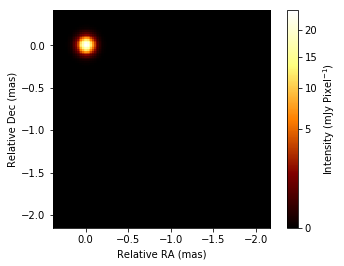

In [5]:
# This command can create an empty image. The final option uvfitsfile is optional, and can read header informations from uvfits file.
initimage = imdata.IMFITS(dx=0.02, nx=128, ny=128, nxref=20, nyref=128-20, angunit="mas", uvfitsfile="3C273DEC16.UVP")

# set beam
initimage.set_beam(**beamprm)

# add a Gaussian
beamprm["majsize"] = beamprm["minsize"]
initimage = initimage.add_gauss(totalflux=1, **beamprm) # this can add a circular or elliptical gaussian to the image

# show imagee
initimage.imshow(scale="gamma", fluxunit="mJy", saunit="pixel", colorbar=True)

Before starting imaging, let's make a table for visibility amplitudes. Since they could have residual gain errors, let's add additional errors for residual errrors. We can copy tables for full complex visibilities and add potential systematic errors.

In [6]:
atable = vtable.copy()  # Table for amplitudes
atable = atable.add_error(error=atable["amp"]*0.05)  # add 5% errors in quadrature

Then, now is the time to make the first image! The simplest imaging function is imaging.lbfgs.imaging.

In [7]:
imprm = {}

# Data sets to be used
#imprm["vistable"]=vtable # If we use full complex visibility
imprm["amptable"]=atable # use amplitudes
imprm["bstable"]=btable # use closure phases
imprm["catable"]=ctable # use closure amplitudes

# Regularization functions: 
#   we have 5 reglarization functions:
#      l1-norm: "l1_xxxxx"
#      Total Variation (TV): "tv_xxxxx"
#      Total Squared Variation (TSV): "tsv_xxxxx"
#       Relative Entropy (KL divergence): "kl_xxxxx"
#       GS Entropy: "gs_xxxxxx"
#   
#   The most important parameter is "lambda", which is the hypter parameter of imaging.
#   If xx_lambda > 0: then the corresponding regularization function will be used.
#
#   l1-norm
imprm["l1_lambda"]=1.
#imprm["l1_prior"]=prior image   # this option will use weighted l1 regularization using prior image
#
#   TSV
imprm["tsv_lambda"]=1.
#imprm["tsv_prior"]= prior image   # this option will use weighted TSV regularization using prior image
#
#   TV
imprm["tv_lambda"]=1.
#imprm["tv_prior"]= prior image   # this option will use weighted-TV regularization using prior image
#
#   KL-MEM
imprm["kl_lambda"]=-1.
#imprm["kl_prior"]= prior image   # prior image. If it is not specified, then flat prior will be adopted.
#
#   GS-MEM
imprm["gs_lambda"]=-1
#imprm["gs_prior"]= prior image   # prior image. If it is not specified, then flat prior will be adopted.

# Other regularization functions for scaling amplitudes or fixing the phase center.
#
#   Total flux regularization
imprm["tfd_lambda"]=1
imprm["totalflux"]=vtable.amp.max()
#
#   Cent-of-mass regularization
imprm["cen_lambda"]=0.1
imprm["cen_alpha"]=3.0 # the power of the centroid. 1 gives the regularization using the exact center of the mass. 
                                             # The higher value gives regularization using the region close to the peak of the image.

# iteration number
imprm["niter"]=1000 

# imaging window: if you want to use the imaging region to limit your imaging pixels.
#imprm["imregion"]=imregion 

Closure imaging is non-convex optimization, and sometimes we fails on some local minima with many noises. We may kill some noise artifacts by blurring, thresholding and do imaging iteratively. We may also use reweighted sparse regularizations, which can enhance sparcity of images. Here, we use blurring and also reweighting l1-norm to kill noises in the image.

In [ ]:
for i in range(5):
    if i ==0:
        editimage = initimage
    else:
        editimage = outimage.soft_threshold(0.01).convolve_gauss(**beamprm)   # thresholding & bluring the image
    outimage = imaging.lbfgs.imaging(editimage,**imprm)

(<matplotlib.image.AxesImage at 0x1c25632210>,
 <matplotlib.colorbar.Colorbar at 0x1c25773350>)

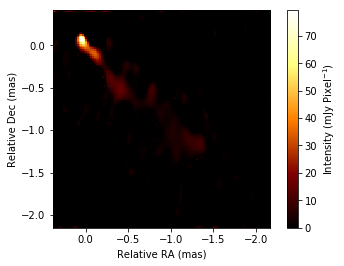

In [9]:
outimage.imshow(scale="linear", cmap=cm.afmhot, fluxunit="mJy", saunit="pixel", colorbar=True)

We can also do iterative imaging with self-calibrations

In [ ]:
# This is the loop for selfcalibration
for i in range(4):
    #  Imaging part
    if i < 2: # for the first two times, we will use amplitudes
        imprm["amptable"] = atable
        imprm["vistable"] = None
        imprm["cen_lambda"] = 1  # don't forget to switch off the centroid regularizer, since now we have absolute position information from full complex visibilities.
    else:
        imprm["amptable"] = None
        imprm["vistable"] = vtable
        imprm["cen_lambda"] = -1  # don't forget to switch off the centroid regularizer, since now we have absolute position information from full complex visibilities.
    
    for j in range(5):
        if j ==0:
            editimage = initimage
        else:
            editimage = outimage.soft_threshold(0.01).convolve_gauss(**beamprm).comshift(alpha=3)   # thresholding & bluring the image
        outimage = imaging.lbfgs.imaging(editimage,**imprm)
    
    # here we do selfcal
    caltable = uvfits.selfcal(outimage)
    uvfits = uvfits.apply_cltable(caltable)
    
    # recreate vistable and amptable
    vtable = uvfits.make_vistable()
    atable = vtable.copy()
    atable = atable.add_error(error=atable.amp * 0.05)

(<matplotlib.image.AxesImage at 0x1c27e0ccd0>,
 <matplotlib.colorbar.Colorbar at 0x1c25865e10>)

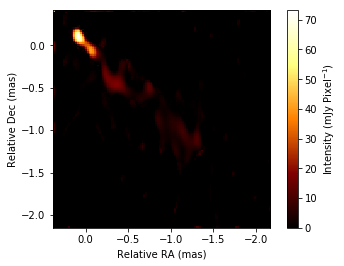

In [11]:
outimage.imshow(scale="linear", cmap=cm.afmhot, fluxunit="mJy", saunit="pixel", colorbar=True)

## Image inspections

You can check the goodness of fitting between the image and data sets by following functions:

1. "eval_image" returns a model visibilities which is Fourier coefficient of the intensity of the image.
2. "residual_image" calculates the residual between real and model visibilities. 
3. "chisq_image" estimates the a (mean square) standardized residual, $\chi$ ($\chi_{\rm r}$). 

These functions can be adapted to complex visibilities, bispectra, and log closure amplitudes. 
Here, we show an example for modeling complex visibilities.

Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.


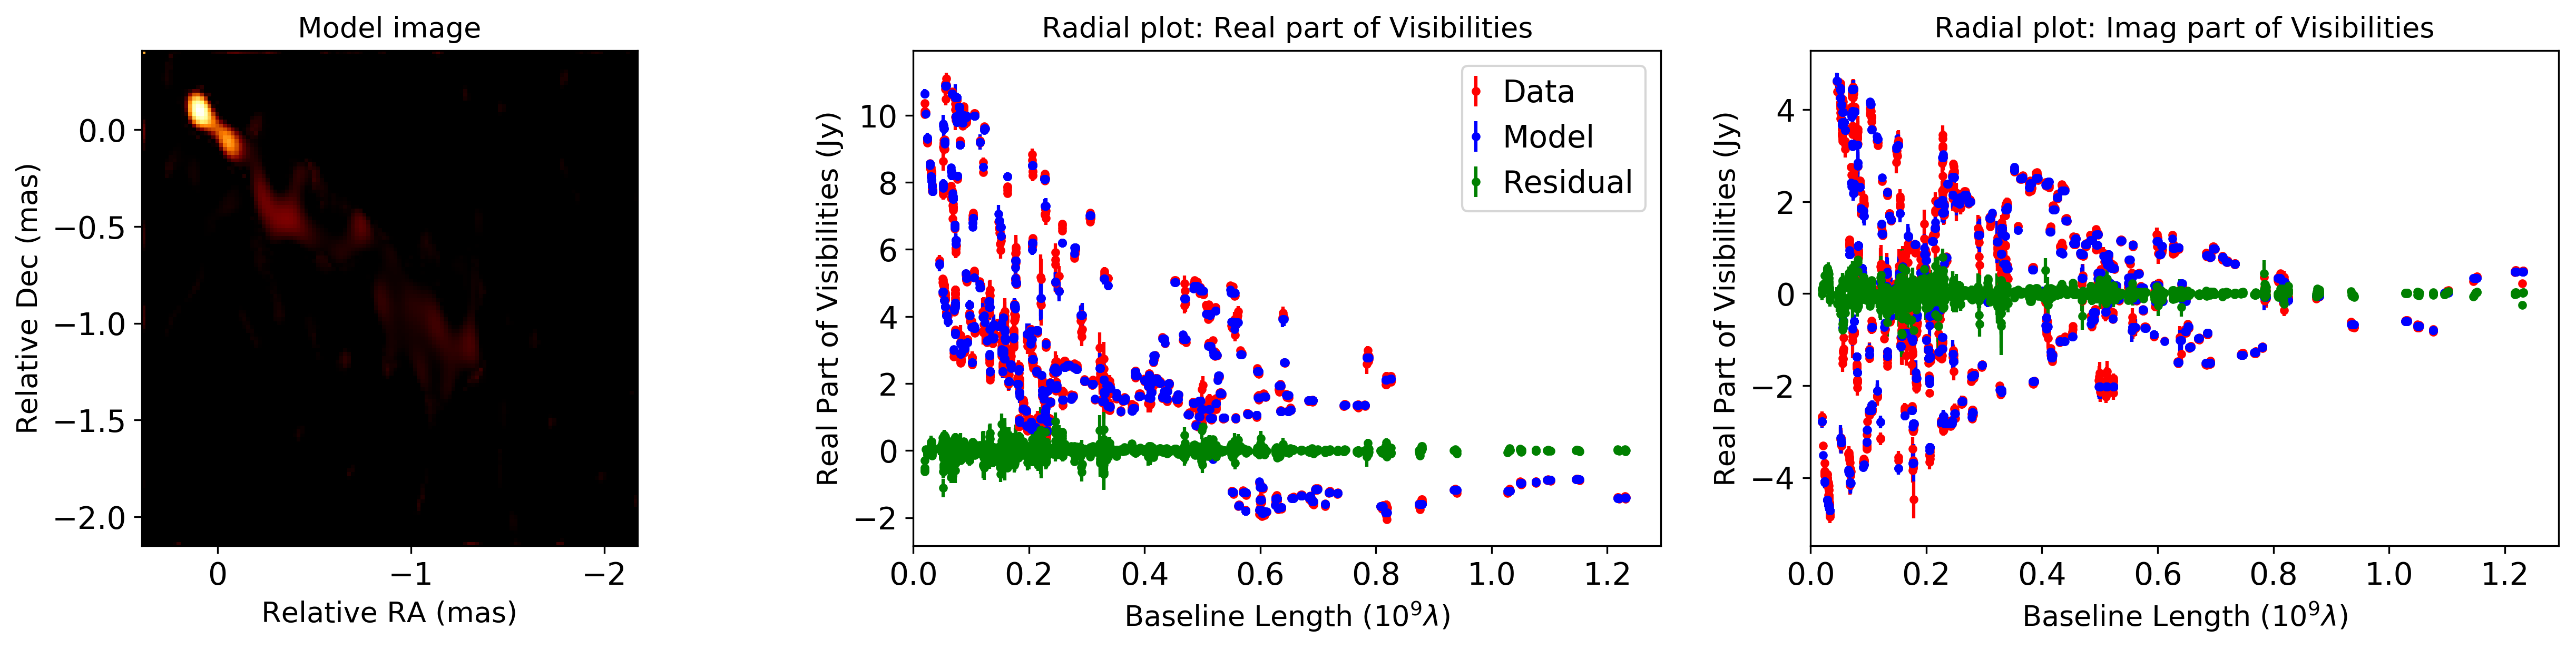

Imaging Window: Not Specified. We calcurate the image on all the pixels.
Complex visibilities  : chisquare and reduced chisquare are 12059.28 and 3.15.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Visibility amplitudes : chisquare and reduced chisquare are 5567.42 and 2.91.


In [12]:
# model complex visibilities based on an input image
vtable_model = vtable.eval_image(outimage)

# residual between real and model visibilities
vtable_residual = vtable.residual_image(outimage)

# You can also check the visibilies as a function of projected baseline length
util.matplotlibrc(ncols=3, width=500, height=300)
fig, axs = plt.subplots(ncols=3)

plt.sca(axs[0])
plt.title("Model image")
outimage.imshow(cmap=cm.afmhot)

plt.sca(axs[1])
plt.title("Radial plot: Real part of Visibilities")
vtable.radplot(datatype="real",label="Data",color="red")
vtable_model.radplot(datatype="real",label="Model",color="blue")
vtable_residual.radplot(datatype="real",label="Residual",color="green")
plt.legend(loc='upper right',markerscale=1.,handlelength=0.1)

plt.sca(axs[2])
plt.title("Radial plot: Imag part of Visibilities")
vtable.radplot(datatype="imag",label="Imag",color="red")
vtable_model.radplot(datatype="imag",label="Model",color="blue")
vtable_residual.radplot(datatype="imag",label="Residual",color="green")
plt.show()

# You can estimate chisquares and reduced chisquares.
print("Complex visibilities  : chisquare and reduced chisquare are %1.2f and %1.2f."%(vtable.chisq_image(outimage)))
print("Visibility amplitudes : chisquare and reduced chisquare are %1.2f and %1.2f."%(vtable.chisq_image(outimage,amptable=True)))

You can also adapt the same functions to bispectra and log closure amplitudes.

Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Imaging Window: Not Specified. We calcurate the image on all the pixels.


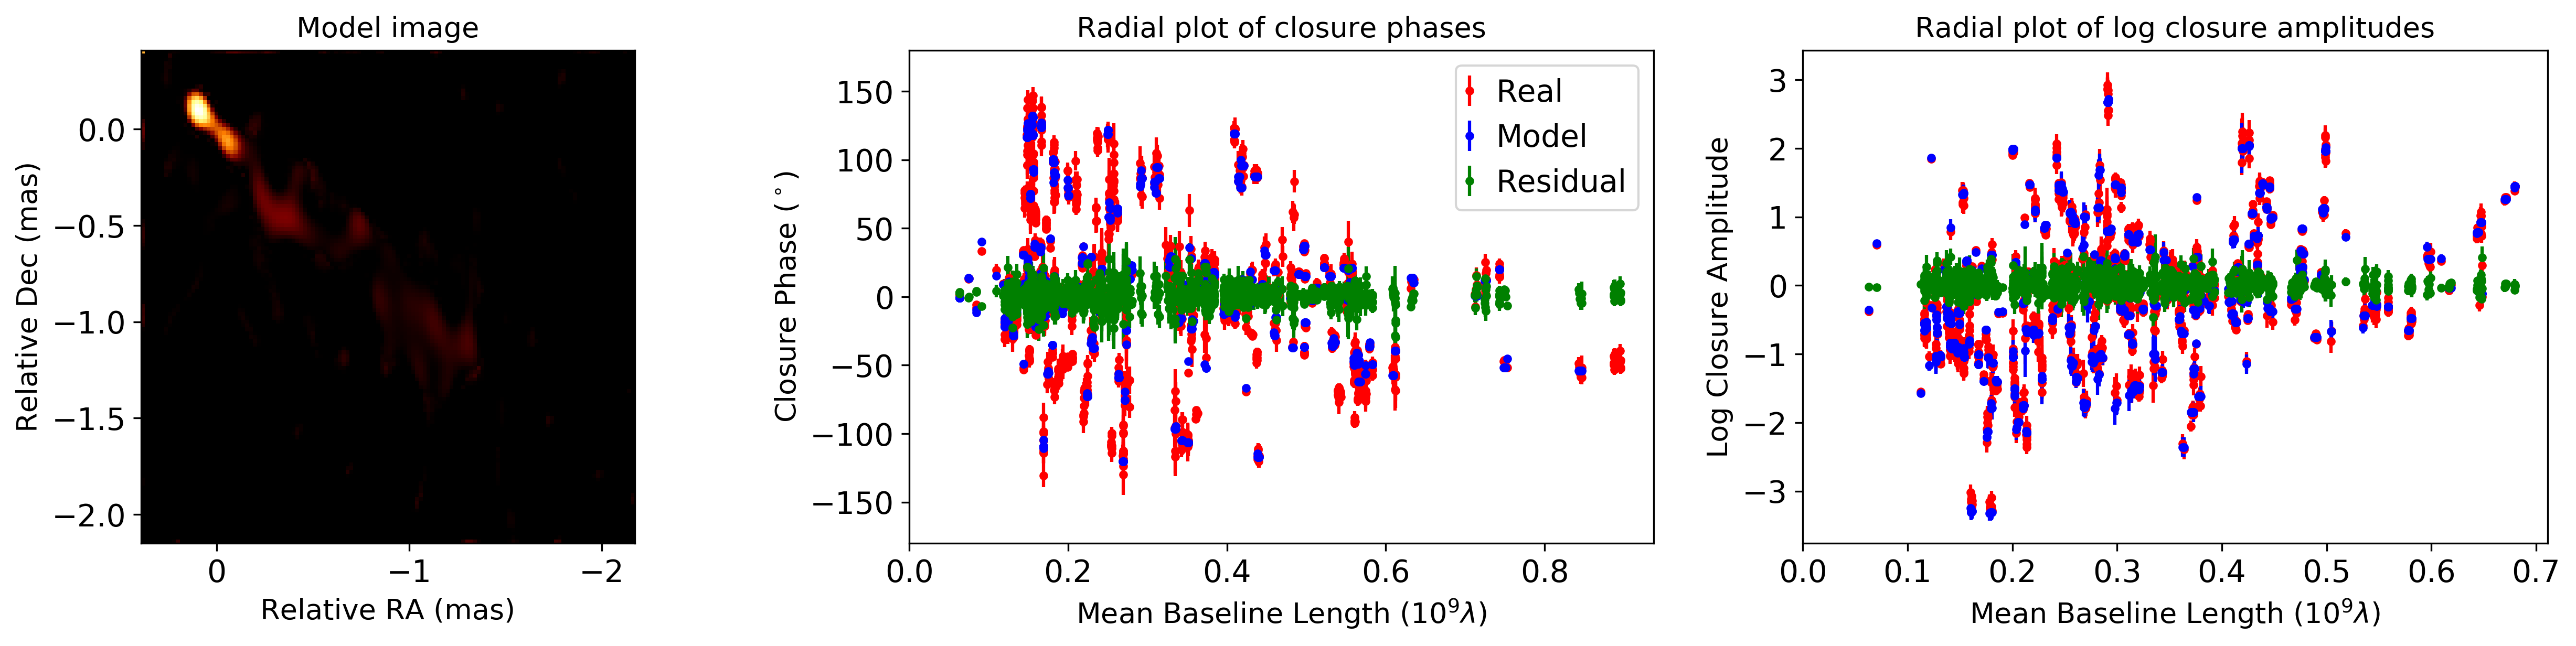

Imaging Window: Not Specified. We calcurate the image on all the pixels.
Closure phases        : chisquare and reduced chisquare are 2964.93 and 2.02.
Imaging Window: Not Specified. We calcurate the image on all the pixels.
Log closure amplitudes: chisquare and reduced chisquare are 1799.69 and 1.28.


In [13]:
# model bispectra based on an input image
btable_model = btable.eval_image(outimage)

# residual between real and model bispectra
btable_residual = btable.residual_image(outimage)

# model log closure amplitudes based on an input image
ctable_model = ctable.eval_image(outimage)

# residual between real and model bispectra
ctable_residual = ctable.residual_image(outimage)

# You can also check the visibilities as a function of projected baseline length
util.matplotlibrc(ncols=3, width=500, height=300)
fig, axs = plt.subplots(ncols=3)

plt.sca(axs[0])
plt.title("Model image")
outimage.imshow(cmap=cm.afmhot)

plt.sca(axs[1])
plt.title("Radial plot of closure phases")
btable.radplot(label="Real",color="red")
btable_model.radplot(label="Model",color="blue")
btable_residual.radplot(label="Residual",color="green")
plt.legend(loc='upper right',markerscale=1.,handlelength=0.1)

plt.sca(axs[2])
plt.title("Radial plot of log closure amplitudes")
ctable.radplot(label="Real",color="red")
ctable_model.radplot(label="Model",color="blue")
ctable_residual.radplot(label="Residual",color="green")
plt.show()

# You can estimate chisquares and reduced chisquares.
print("Closure phases        : chisquare and reduced chisquare are %1.2f and %1.2f."%(btable.chisq_image(outimage)))
print("Log closure amplitudes: chisquare and reduced chisquare are %1.2f and %1.2f."%(ctable.chisq_image(outimage)))

You can make summary pdf figures and csv file, showing residuals, residual statistics
and chisquares between the image and data sets. Here are example outputs.

- [plot_model_fcv.pdf](plot_model_fcv.pdf)
- [plot_model_cphase.pdf](plot_model_cphase.pdf)
- [plot_model_logcamp.pdf](plot_model_logcamp.pdf)

In [ ]:
# You can make a summary plot for image inspections.
# Complex visibilities
vtable.plot_model_fcv(outimage,filename="plot_model_fcv.pdf")

# Closure phases
btable.plot_model(outimage,filename="plot_model_cphase.pdf")

# Log closure amplitudes
ctable.plot_model(outimage,filename="plot_model_logcamp.pdf")

## Acknowledgement

This notebook makes use of 43 GHz VLBA data from the VLBA-BU Blazar Monitoring Program (VLBA-BU-BLAZAR; 
http://www.bu.edu/blazars/VLBAproject.html), funded by NASA through the Fermi Guest Investigator Program. The VLBA is an instrument of the National Radio Astronomy Observatory. The National Radio Astronomy Observatory is a facility of the National Science Foundation operated by Associated Universities, Inc.